<a href="https://colab.research.google.com/github/davidjhwu/Seili-2020/blob/master/avm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#|hide
#|skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
!pip install pyarrow
!pip install pydicom kornia opencv-python scikit-image nbdev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.4 MB/s eta 0:00:00


In [ ]:
import os
import pydicom as  dicom
import numpy as np
import re
from collections import defaultdict
import csv
from PIL import Image
import argparse
import json
import glob

In [ ]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.data.all import *
from fastai.medical.imaging import *

In [ ]:
  from nbdev.showdoc import *
import pandas as pd

In [ ]:
path = '/content/drive/MyDrive/AVM_Data/'
sys.path.append(path)

%cd $path

/content/drive/.shortcut-targets-by-id/1CvKP-8hsWg5Y6E8RSXfHeaKu2gjWIB7e/AVM_Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!cd data
#!unzip \*.zip
#!mv *.zip ../zips

In [ ]:


for root, subdirs, files in os.walk("data"):
  for sub in subdirs:
    mrn_search = re.search("[a-zA-Z]+_[a-zA-Z]+_0+([0-9]+)_[0-9]+", sub, re.IGNORECASE)  #lastname + firstname + _0 MRN + date of tx
    if mrn_search:
      mrn = mrn_search.group(1)
      rtplan_file = glob.glob(f"/data/{sub}/*RTPlan*.dcm")
      if rtplan_file:
          rtplan = dicom.read_file(rtplan_file[0])
          target_volumes = rtplan.RTROIObservationsSequence
          target_coords = []
          for volume in target_volumes:
              if volume.ROIObservationLabel == 'TARGET': # assuming the target volume label is "TARGET"
                contour_data = volume.ContourSequence[0].ContourData
                coords = np.array(contour_data).reshape(-1, 3)[:, :2] # extract the x, y coordinates
                target_coords.append(coords)

                         # find the best DICOM slice(s) that contain the target volumes
                target_slices = []
                for coords in target_coords:
                    # we assume that the DICOM files containing the target volumes have the word "TARGET" in their file names
                    target_files = glob.glob(f"/data/{sub}/*TARGET*.dcm")
                    for target_file in target_files:
                        ds = dicom.dcmread(target_file)
                        img_coords = np.array(ds.ImagePositionPatient)[:2]
                        if np.all(np.isin(img_coords, coords, assume_unique=True)):
                            target_slices.append(target_file)
                
                if target_slices:
                    target_slices.sort()
                    best_slice = target_slices[-1]
                    print(best_slice)
      
    break
    imgs = glob.glob(f"data/*{mrn}*/IMG*.dcm")
    imgs.sort()

      



                
               

  


In [ ]:
df = pd.read_csv("avm_labels2.csv")
df.head()

,mrn,label
0,51011552,0
1,50025300,0
2,7184641,0
3,40607493,1
4,51091026,0


In [ ]:
# def get_best_slice(mrn):
#   imgs = glob.glob(f"data/*{mrn}*/IMG*.dcm")
#   imgs.sort()
#   best_img = int(imgs[-1][-7:-4])//2
#   return best_img

In [ ]:
avm = DataBlock(
  blocks=(ImageBlock(cls=PILDicom), CategoryBlock),
  get_x=lambda x:glob.glob(f"avm_slices/*{mrn}.dcm")[0],    #change to mrn.dcm?
  get_y=lambda x:x[1],
  batch_tfms=[*aug_transforms(size=224),Normalize.from_stats(*imagenet_stats)]
)

In [ ]:
dls = avm.dataloaders(df.values, bs=4)

IndexError: ignored

In [ ]:
dls.show_batch(max_n=16)

NameError: ignored

In [ ]:
# Removed MRNs 50330554, 40697325, 453939, 29779758 as data was unavailable
# for x in df.values:
#   print(x[1], glob.glob(f"avm_slices/*{x[0]}.dcm")[0])

In [ ]:
for x in df.values:
  print(x[1], glob.glob(f"avm_slices/*{x[0]}.dcm"))

0 ['avm_slices/0051011552.dcm']
0 ['avm_slices/0050025300.dcm']
0 ['avm_slices/0007184641.dcm']
1 ['avm_slices/0040607493.dcm']
0 ['avm_slices/0051091026.dcm']
1 ['avm_slices/0051121132.dcm']
0 []
0 []
0 []
1 ['avm_slices/0029331378.dcm']
1 ['avm_slices/0040016266.dcm']
0 ['avm_slices/0029517956.dcm']
1 ['avm_slices/0026001398.dcm']
0 []
1 ['avm_slices/0031032889.dcm']
0 ['avm_slices/0002814600.dcm']
1 ['avm_slices/0050145542.dcm']
1 ['avm_slices/0031776377.dcm']
0 ['avm_slices/0006530529.dcm']
1 ['avm_slices/0000464339.dcm']
0 ['avm_slices/0040192331.dcm']
0 ['avm_slices/0051206434.dcm']
0 ['avm_slices/0040575963.dcm']
1 ['avm_slices/0040380093.dcm']
1 ['avm_slices/0040013123.dcm']
1 ['avm_slices/0031725054.dcm']
0 ['avm_slices/0029475970.dcm']
1 ['avm_slices/0060167200.dcm']
1 ['avm_slices/0002284670.dcm']
0 ['avm_slices/0060373076.dcm']
1 ['avm_slices/0001100432.dcm']
1 ['avm_slices/0031727805.dcm']
0 ['avm_slices/0050006327.dcm']
1 ['avm_slices/0029433252.dcm']
1 ['avm_slices/00606

# New Section

In [ ]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
len(dls.valid_ds)

8

In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
learn.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

SuggestedLRs(valley=0.0014454397605732083)

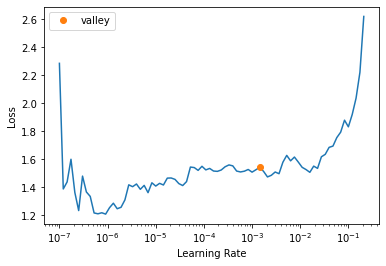

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(1, base_lr = 9e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.724146,0.760728,0.500000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,2.705215,1.001611,0.500000,00:15


In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.308895,4.161944,0.500000,00:16
1,3.052222,8.679427,0.500000,00:16
2,2.704090,0.845034,0.500000,00:16
3,2.318698,1.196049,0.500000,00:15
4,2.213934,0.763663,0.500000,00:15
5,2.020145,1.751575,0.500000,00:16
6,1.770906,0.861553,0.500000,00:15
7,1.646689,0.842706,0.500000,00:16
8,1.586550,0.784068,0.500000,00:15
9,1.493188,0.801136,0.500000,00:16


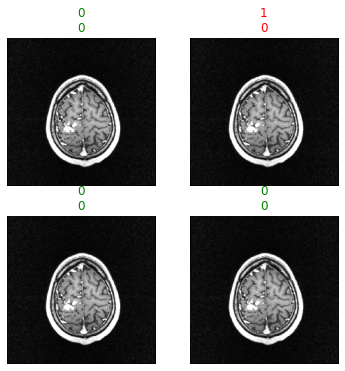

In [ ]:
learn.show_results(max_n=16)

In [ ]:
interp = Interpretation.from_learner(learn)

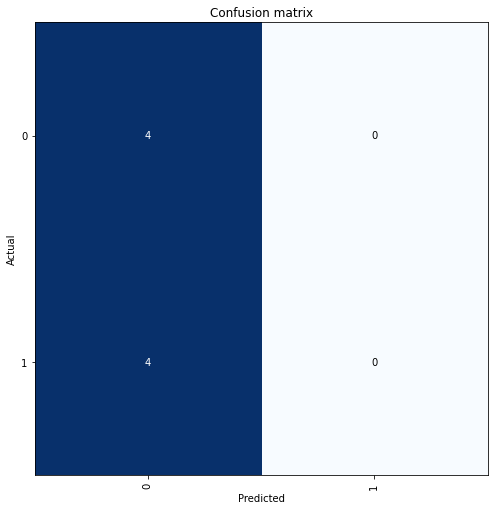

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [ ]:
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
sensitivity = tp/(tp + fn)
print(f"Sensitivity: {sensitivity}")
specificity = tn/(fp + tn)
print(f"Specificity: {specificity}")
ppv = tp/(tp+fp)
print(f"Positive Predictive Value: {ppv}")
npv = tn/(tn+fn)
print(f"Negative Predictive Value: {npv}")

TN: 4, FP: 0, FN: 4, TP: 0
Sensitivity: 0.0
Specificity: 1.0
Positive Predictive Value: nan
Negative Predictive Value: 0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


In [ ]:
val = dls.valid_ds.cat
#val[0]

In [ ]:
prevalence = 8./40
prevalence

0.2

In [ ]:
accuracy = (sensitivity * prevalence) + (specificity * (1 - prevalence))
print(f"Accuracy: {accuracy}")

Accuracy: 0.8


In [ ]:
preds, y, loss = learn.get_preds(with_loss=True)
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.5


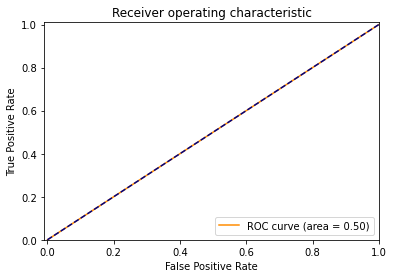

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")